In [117]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(1, "./utils/")
import HH, Stimuli
from neuron import h
h.load_file("stdrun.hoc")
from neuron.units import mV, ms
import time
import pandas as pd
import matplotlib.pylab as pl
import matplotlib as mpl
import seaborn as sns
from collections import Counter
from sklearn.neighbors import KernelDensity
import math

In [2]:
data_dir = './data/nst_distribution_evolution/'
figures_dir = './figures/'

In [3]:
results_files = os.listdir(f'{data_dir}results/')

results_stim_ids = [int(f.split('_')[1]) for f in results_files]

In [4]:
ns = [n for n in range(3, 21)]
num_histories = 1000
stim_types = ['base','lw','lt','lwlt','burst']

## read stimuli

In [5]:
stim_files = os.listdir(f'{data_dir}stimuli/')
stim_ids = [stim_file.strip('.json').split('_')[1] for stim_file in stim_files]

['777216825',
 '271259078',
 '246988590',
 '438217066',
 '167008283',
 '354415559',
 '786114754',
 '828122328',
 '70677970',
 '825999927',
 '933144106',
 '969898339',
 '181153586',
 '693397914',
 '945760822',
 '711204005',
 '791949566',
 '630015239',
 '55459750',
 '741486600',
 '484962505',
 '298231602',
 '284651838',
 '284711596',
 '320707323',
 '794570465',
 '241317267',
 '920928595',
 '159302341',
 '157764381',
 '236629911',
 '165457091',
 '264927774',
 '551989549',
 '763257292',
 '399399764',
 '940542047',
 '194564521',
 '494972901',
 '699610293',
 '714775919',
 '231417008',
 '728818259',
 '161040162',
 '94154888',
 '154939225',
 '129203894',
 '764375805',
 '891533724',
 '378397760',
 '985102273',
 '762566329',
 '662354249',
 '130592060',
 '40178325',
 '991134877',
 '198374557',
 '311757779',
 '843014686',
 '571721008',
 '208818644',
 '639952663',
 '570510055',
 '294372488',
 '231697608',
 '782210541',
 '46518012',
 '930657453',
 '177588297',
 '753688744',
 '8599911',
 '813049725',

In [6]:
stimuli = {}

for stim_file in stim_files:
    stim_id = stim_file.strip('.json').split('_')[1]
    with open(f'{data_dir}stimuli/{stim_file}', 'r') as fin:
        stimuli[stim_id] = json.load(fin)

In [120]:
# get expected stimuli intervals
intervals = []
for stim_id in stim_ids:
    for stim_ind in stimuli[stim_id]:
        _stimuli = stimuli[stim_id][stim_ind]
        intervals += [_stimuli[i+1][1] - _stimuli[i][1] for i in range(len(_stimuli)-1)]

## spike determinism criteria
Here we define a metric to determine if a set of responses are deterministic or not.

In [9]:
# spike determinism criteria
spike_ratio_upper_bound = 0.99
spike_ratio_lower_bound = 0.01
nst_std_limit = .1 #ms

In [10]:
spike_ratios = {int(stim_id):{} for stim_id in stim_ids}
spike_determinisms = {int(stim_id):{} for stim_id in stim_ids}

progress = 0.0
print('______PROGRESS______')
for i, file in enumerate(results_files):
    stim_type = file.split('_')[0]
    stim_id = int(file.split('_')[1])
    stim_ind = int((file.split('_')[2]).strip('.json'))
    
    if stim_type == 'base':
        with open(f'{data_dir}results/{file}', 'r') as fin:
            results = json.load(fin)
        _spike_ratios = []
        _spike_determinisms = []
        for n in ns:
            spike_ratio = np.sum(~np.isnan(results[str(n)])) / num_histories
            _spike_ratios.append(spike_ratio)

            if spike_ratio < spike_ratio_lower_bound:
                _spike_determinisms.append(-1) #'deterministic nonspiking'
            elif spike_ratio > spike_ratio_upper_bound:
                if np.nanstd(results[str(n)]) < nst_std_limit:
                    _spike_determinisms.append(1) #'deterministic spiking'
                else:
                    _spike_determinisms.append(0.5) #'non-deterministic spiking'
            else:
                _spike_determinisms.append(0) #'non-deterministic'

        spike_ratios[stim_id][stim_ind] = _spike_ratios
        spike_determinisms[stim_id][stim_ind] = _spike_determinisms
        
    if progress < i/len(results_files):
        print('=', end='')
        progress+=0.05

______PROGRESS______

In [11]:
flips = []
for stim_id in stim_ids:
    
    for stim_ind in spike_determinisms[int(stim_id)]:
        _spike_determinism = spike_determinisms[int(stim_id)][stim_ind]
        
        for i in range(17):
            n = i + 3
            pre = _spike_determinism[i]
            post = _spike_determinism[i + 1]
            
            if (pre != post):
                _stimuli = stimuli[stim_id][str(stim_ind)]
                flips.append([stim_id, stim_ind, n, pre, post, _stimuli[-n][0], _stimuli[-n-1][0],
                              _stimuli[-n][1] - _stimuli[-n-1][1]])
                    
flips = pd.DataFrame(
    flips, 
    columns=[
        'stim_id','stim_ind','n','pre_determinism','post_determinism','pre_stim_type','post_stim_type', 'interval'
    ]
)

In [12]:
flips['unique_id'] = [str(flips['stim_id'].iloc[i]) + str(flips['stim_ind'].iloc[i]) for i in range(flips.shape[0])]

In [13]:
flips[((flips['pre_determinism'] == 0.0) & (flips['post_determinism'] == 1.0))]

,stim_id,stim_ind,n,pre_determinism,post_determinism,pre_stim_type,post_stim_type,interval,unique_id
2,777216825,35,6,0.0,1.0,e,i,15.462500,77721682535
6,777216825,54,10,0.0,1.0,e,e,1.671396,77721682554
17,777216825,30,11,0.0,1.0,e,e,8.532989,77721682530
29,777216825,87,7,0.0,1.0,e,e,17.633356,77721682587
69,777216825,57,10,0.0,1.0,e,e,6.484551,77721682557
...,...,...,...,...,...,...,...,...,...
9159,450216176,22,7,0.0,1.0,e,i,13.214815,45021617622
9162,450216176,37,3,0.0,1.0,e,i,13.655162,45021617637
9165,450216176,87,15,0.0,1.0,i,i,1.201250,45021617687
9176,450216176,35,14,0.0,1.0,i,e,1.452749,45021617635


nondet2detspiking


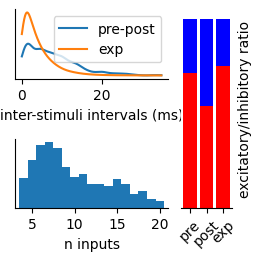

In [184]:
def plot_transition(pre, post, name):
    _slice = flips[
        ((flips['pre_determinism'] == pre)) & (flips['post_determinism'] == post)
    ]

    pre_stim_counts = Counter(list(_slice['pre_stim_type']))
    pre_ex_ratio = pre_stim_counts['e'] / _slice.shape[0]
    post_stim_counts = Counter(list(_slice['post_stim_type']))
    post_ex_ratio = post_stim_counts['e'] / _slice.shape[0]

    # KDE specifics
    x_max=35
    bandwidth=1
    X_plot = np.linspace(0, x_max, 1000)[:, np.newaxis]
    
    print(name)

    fig, axes = plt.subplot_mosaic([['a','c'],['b','c']], 
                                   width_ratios=[3, 1], figsize=(2.5, 2.5), layout="constrained")
    #fig, axes = plt.subplots(2,1, figsize=(6.5,4))

    # conditional inter-stimuli-intervals
    #interval_bins = np.arange(0, 40, 2)
    #axes[0].hist(_slice['interval'], density=True, bins=interval_bins)
    conditional_intervals = np.array(_slice['interval']).reshape(-1, 1)
    kde = KernelDensity(
        kernel='gaussian', 
        bandwidth=bandwidth).fit(conditional_intervals)
    log_dens = kde.score_samples(X_plot)
    axes['a'].plot(X_plot, np.exp(log_dens))

    # inter-stimuli-intervals
    #axes[0].hist(intervals, density=True, alpha=0.5, edgecolor='red', bins=interval_bins)
    kde = KernelDensity(
        kernel='gaussian', 
        bandwidth=bandwidth).fit(np.array(intervals).reshape(-1, 1))
    log_dens = kde.score_samples(X_plot)
    axes['a'].plot(X_plot, np.exp(log_dens))
    axes['a'].set_xlabel('inter-stimuli intervals (ms)')
    axes['a'].spines['top'].set_visible(False)
    axes['a'].spines['right'].set_visible(False)
    axes['a'].set_yticks([])
    axes['a'].legend(['pre-post','exp'])

    axes['b'].hist( _slice['n'], bins = range(3,21))
    axes['b'].set_xticks(np.arange(4.5,20.5,5))
    axes['b'].set_xticklabels(np.arange(5,21,5))
    axes['b'].set_xlim(2.5, 20.5)
    axes['b'].spines['top'].set_visible(False)
    axes['b'].spines['right'].set_visible(False)
    axes['b'].set_yticks([])
    axes['b'].set_xlabel('n inputs')
    
    axes['c'].bar([1,2,3],[pre_ex_ratio, post_ex_ratio, 0.75], color='red')
    axes['c'].bar([1,2,3],[1-pre_ex_ratio, 1-post_ex_ratio, .25], 
                  bottom=[pre_ex_ratio, post_ex_ratio, 0.75], color='blue')
    axes['c'].set_xticks([1,2,3])
    axes['c'].set_xticklabels(['pre','post','exp'], rotation = 45)
    axes['c'].yaxis.set_label_position("right")
    #axes['c'].yaxis.tick_right()
    axes['c'].set_ylabel('excitatory/inhibitory ratio')
    axes['c'].spines['top'].set_visible(False)
    axes['c'].spines['right'].set_visible(False)
    axes['c'].spines['left'].set_visible(False)
    axes['c'].set_yticks([])
    plt.savefig(f'{figures_dir}{name}.svg', format='svg')
    plt.show()
plot_transition(0.0, 1.0, 'nondet2detspiking')

nondet2detnonspiking


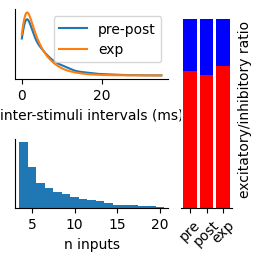

In [185]:
plot_transition(0.0, -1.0, 'nondet2detnonspiking')

non-det2det non-spiking


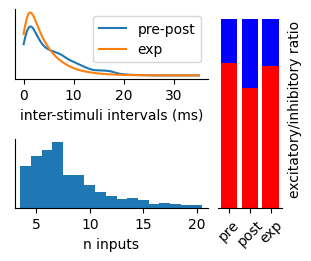

In [181]:
plot_transition(0.0, 0.5, 'non-det2det non-spiking')

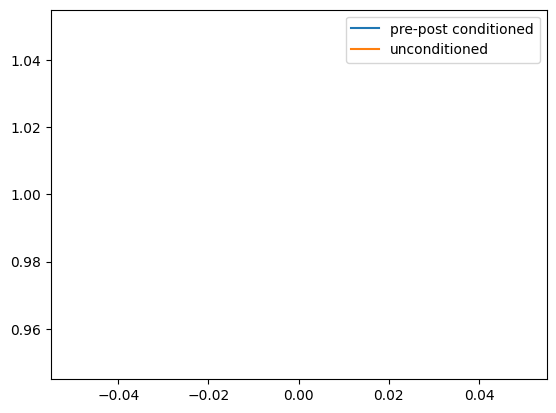

In [188]:
plt.plot((0,0),(1,1))
plt.plot((0,0),(1,1))
plt.legend(['pre-post conditioned','unconditioned'])
plt.savefig(f'{figures_dir}transition_legend.svg', format='svg')

## Matplotlib state diagram

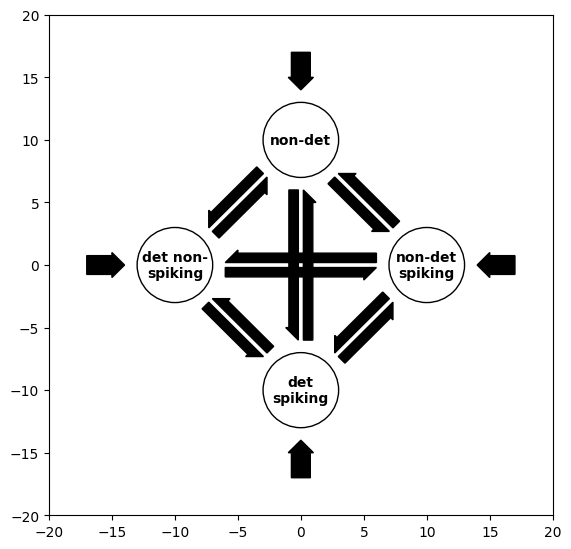

In [189]:
import matplotlib.pyplot as plt

# Define the states and transitions
states = ['A', 'B', 'C', 'D']
state_names = {
    'A':'non-det',
    'B':'non-det\nspiking',
    'C':'det\nspiking',
    'D':'det non-\nspiking'
}

node_pos = {
    'A':(0,10),
    'B':(10,0),
    'C':(0,-10),
    'D':(-10,0)
}

bidir_offset = .2
diag_offset = math.sqrt(2*((bidir_offset)**2))/2

radius_offset = 4
diag_radius_offset = math.sqrt(2*((radius_offset)**2))/2

arrow_l = 1

transitions = [
    ('A', 'B', 
     (node_pos['A'][0]-diag_offset+diag_radius_offset, node_pos['A'][1]-diag_offset-diag_radius_offset), 
     (node_pos['B'][0]-diag_offset-diag_radius_offset, node_pos['B'][1]-diag_offset+diag_radius_offset),
    ),
    ('A', 'C', 
     (node_pos['A'][0]-bidir_offset, node_pos['A'][1]-radius_offset), 
     (node_pos['C'][0]-bidir_offset, node_pos['C'][1]+radius_offset),
    ),
    ('A', 'D', 
     (node_pos['A'][0]-diag_offset-diag_radius_offset, node_pos['A'][1]+diag_offset-diag_radius_offset), 
     (node_pos['D'][0]-diag_offset+diag_radius_offset, node_pos['D'][1]+diag_offset+diag_radius_offset),
    ),
    ('B', 'A', 
     (node_pos['B'][0]+diag_offset-diag_radius_offset, node_pos['B'][1]+diag_offset+diag_radius_offset), 
     (node_pos['A'][0]+diag_offset+diag_radius_offset, node_pos['A'][1]+diag_offset-diag_radius_offset),
    ), 
    ('B', 'C', 
     (node_pos['B'][0]-diag_offset-diag_radius_offset, node_pos['B'][1]+diag_offset-diag_radius_offset),
     (node_pos['C'][0]-diag_offset+diag_radius_offset, node_pos['C'][1]+diag_offset+diag_radius_offset), 
    ),
    ('B', 'D', 
     (node_pos['B'][0]-radius_offset, node_pos['B'][1]+bidir_offset), 
     (node_pos['D'][0]+radius_offset, node_pos['D'][1]+bidir_offset),
    ), 
    ('C', 'A', 
     (node_pos['C'][0]+bidir_offset, node_pos['C'][1]+radius_offset), 
     (node_pos['A'][0]+bidir_offset, node_pos['A'][1]-radius_offset),
    ),
    ('C', 'B', 
     (node_pos['C'][0]+diag_offset+diag_radius_offset, node_pos['C'][1]-diag_offset+diag_radius_offset),
     (node_pos['B'][0]+diag_offset-diag_radius_offset, node_pos['B'][1]-diag_offset-diag_radius_offset), 
    ),
    ('C', 'D', 
     (node_pos['C'][0]+diag_offset-diag_radius_offset, node_pos['C'][1]+diag_offset+diag_radius_offset), 
     (node_pos['D'][0]+diag_offset+diag_radius_offset, node_pos['D'][1]+diag_offset-diag_radius_offset),
    ),
    ('D', 'A', 
     (node_pos['D'][0]+diag_offset+diag_radius_offset, node_pos['D'][1]-diag_offset+diag_radius_offset), 
     (node_pos['A'][0]+diag_offset-diag_radius_offset, node_pos['A'][1]-diag_offset-diag_radius_offset),
    ),
    ('D', 'B', 
     (node_pos['D'][0]+radius_offset, node_pos['D'][1]-bidir_offset), 
     (node_pos['B'][0]-radius_offset, node_pos['B'][1]-bidir_offset),
    ), 
    ('D', 'C', 
     (node_pos['D'][0]-diag_offset+diag_radius_offset, node_pos['D'][1]-diag_offset-diag_radius_offset), 
     (node_pos['C'][0]-diag_offset-diag_radius_offset, node_pos['C'][1]-diag_offset+diag_radius_offset),
    ),
]

# Create the figure and axis
fig, ax = plt.subplots(figsize = (6.5,6.5))

# Set the axis limits
ax.set_xlim([-20, 20])
ax.set_ylim([-20, 20])


# Add the states
for i, state in enumerate(states):
    x = node_pos[state][0]
    y = node_pos[state][1]
    ax.text(x, y, state_names[state], ha='center', va='center', fontsize=10, fontweight='bold')
    ax.add_patch(plt.Circle((x, y), 3, facecolor='white', edgecolor='black'))

# Add the transitions

for transition in transitions:
    x1, y1 = transition[2]
    x2, y2 = transition[3]
    dx, dy = x2 - x1, y2 - y1
    ax.arrow(x1, y1, dx, dy, head_width=2, head_length=arrow_l, width=1.5,
             fc='k', ec='k', shape='left', length_includes_head=True)
    
# Add entries
# non-det
x1, y1 = node_pos['A']
y1 = y1 + radius_offset + 3
x2, y2 = node_pos['A']
y2 = y2 + radius_offset
dx, dy = x2 - x1, y2 - y1
ax.arrow(x1, y1, dx, dy, head_width=2, head_length=arrow_l, width=1.5,
         fc='k', ec='k', length_includes_head=True)

# non-det spiking
x1, y1 = node_pos['B']
x1 = x1 + radius_offset + 3
x2, y2 = node_pos['B']
x2 = x2 + radius_offset
dx, dy = x2 - x1, y2 - y1
ax.arrow(x1, y1, dx, dy, head_width=2, head_length=arrow_l, width=1.5,
         fc='k', ec='k', length_includes_head=True)

# det spiking
x1, y1 = node_pos['C']
y1 = y1 - radius_offset - 3
x2, y2 = node_pos['C']
y2 = y2 - radius_offset
dx, dy = x2 - x1, y2 - y1
ax.arrow(x1, y1, dx, dy, head_width=2, head_length=arrow_l, width=1.5,
         fc='k', ec='k', length_includes_head=True)

# det non-spiking
x1, y1 = node_pos['D']
x1 = x1 - radius_offset - 3
x2, y2 = node_pos['D']
x2 = x2 - radius_offset
dx, dy = x2 - x1, y2 - y1
ax.arrow(x1, y1, dx, dy, head_width=2, head_length=arrow_l, width=1.5,
         fc='k', ec='k', length_includes_head=True)

# Show the plot
plt.savefig(f'{figures_dir}example_transition_diagram.svg', format='svg')
plt.show()


## apply this to our data

In [90]:
# consistent basics
states = ['A', 'B', 'C', 'D']
state_names = {
    'A':'non-det',
    'B':'non-det\nspiking',
    'C':'det\nspiking',
    'D':'det non-\nspiking'
}

state_colors = {
    'A':'purple',
    'B':'red',
    'C':'green',
    'D':'blue'
}

node_pos = {
    'A':(0,10),
    'B':(10,0),
    'C':(0,-10),
    'D':(-10,0)
}

bidir_offset = .2
diag_offset = math.sqrt(2*((bidir_offset)**2))/2

radius_offset = 4.5
diag_radius_offset = math.sqrt(2*((radius_offset)**2))/2

arrow_l = 1
head_width = 12
divisor = 3000 # divides the arrow widths to adjust to counts

## 3-8

In [100]:
# get the entry probabilities
entry_pos = []
_n = 3
for stim_id in stim_ids:
    for stim_ind in spike_determinisms[int(stim_id)]:
        entry_pos.append(spike_determinisms[int(stim_id)][stim_ind][_n - 3])
Counter(entry_pos)

# get the transition probabilities
_slice = flips[(flips['n'] >= 3) & (flips['n'] <=8)]

# nondet2nondetspike (AB)
AB = _slice[(_slice['pre_determinism'] == 0.0) & (_slice['post_determinism'] == 0.5)].shape[0]
# nondetspike2nondet (BA)
BA = _slice[(_slice['pre_determinism'] == 0.5) & (_slice['post_determinism'] == 0.0)].shape[0]
# nondetspike2detspike (BC)
BC = _slice[(_slice['pre_determinism'] == 0.5) & (_slice['post_determinism'] == 1.0)].shape[0]
# detspike2nondetspike (CB)
CB = _slice[(_slice['pre_determinism'] == 1.0) & (_slice['post_determinism'] == 0.5)].shape[0]
# detspike2detnonspike (CD)
CD = _slice[(_slice['pre_determinism'] == 1.0) & (_slice['post_determinism'] == -1.0)].shape[0]
# detnonspike2detspike (DC)
DC = _slice[(_slice['pre_determinism'] == -1.0) & (_slice['post_determinism'] == 1.0)].shape[0]
# detnonspike2nondet (DA)
DA = _slice[(_slice['pre_determinism'] == -1.0) & (_slice['post_determinism'] == 0.0)].shape[0]
# nondet2detnonspike (AD)
AD = _slice[(_slice['pre_determinism'] == 0.0) & (_slice['post_determinism'] == -1.0)].shape[0]
# nondet2detspike (AC)
AC = _slice[(_slice['pre_determinism'] == 0.0) & (_slice['post_determinism'] == 1.0)].shape[0]
# detspike2nondet (CA)
CA = _slice[(_slice['pre_determinism'] == 1.0) & (_slice['post_determinism'] == 0.0)].shape[0]
# nondetspike2detnonspike (BD)
BD = _slice[(_slice['pre_determinism'] == 0.5) & (_slice['post_determinism'] == -1.0)].shape[0]
# detnonspike2nondetspike (DB)
DB = _slice[(_slice['pre_determinism'] == -1.0) & (_slice['post_determinism'] == 0.5)].shape[0]

total = AB+BA+BC+CB+CD+DC+DA+AD+AC+CA+BD+DB

In [101]:
max_transition_value = max(AB,BA,BC,CB,CD,DC,DA,AD,AC,CA,BD,DB)

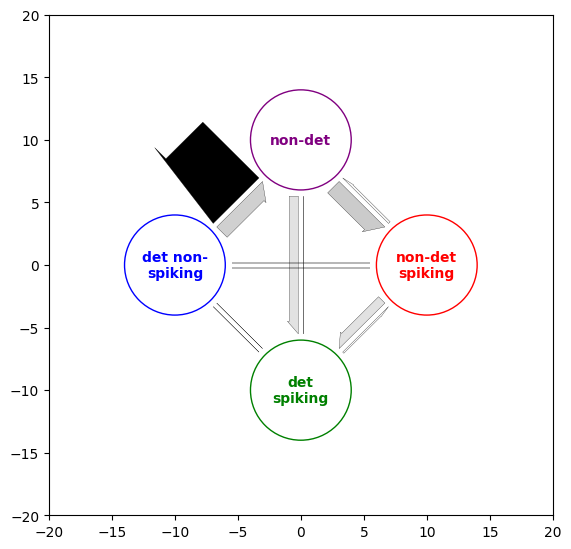

In [102]:
transitions = [
    ('A', 'B', 
     (node_pos['A'][0]-diag_offset+diag_radius_offset, node_pos['A'][1]-diag_offset-diag_radius_offset), 
     (node_pos['B'][0]-diag_offset-diag_radius_offset, node_pos['B'][1]-diag_offset+diag_radius_offset),
     AB
    ),
    ('A', 'C', 
     (node_pos['A'][0]-bidir_offset, node_pos['A'][1]-radius_offset), 
     (node_pos['C'][0]-bidir_offset, node_pos['C'][1]+radius_offset),
     AC
    ),
    ('A', 'D', 
     (node_pos['A'][0]-diag_offset-diag_radius_offset, node_pos['A'][1]+diag_offset-diag_radius_offset), 
     (node_pos['D'][0]-diag_offset+diag_radius_offset, node_pos['D'][1]+diag_offset+diag_radius_offset),
     AD
    ),
    ('B', 'A', 
     (node_pos['B'][0]+diag_offset-diag_radius_offset, node_pos['B'][1]+diag_offset+diag_radius_offset), 
     (node_pos['A'][0]+diag_offset+diag_radius_offset, node_pos['A'][1]+diag_offset-diag_radius_offset),
     BA
    ), 
    ('B', 'C', 
     (node_pos['B'][0]-diag_offset-diag_radius_offset, node_pos['B'][1]+diag_offset-diag_radius_offset),
     (node_pos['C'][0]-diag_offset+diag_radius_offset, node_pos['C'][1]+diag_offset+diag_radius_offset), 
     BC
    ),
    ('B', 'D', 
     (node_pos['B'][0]-radius_offset, node_pos['B'][1]+bidir_offset), 
     (node_pos['D'][0]+radius_offset, node_pos['D'][1]+bidir_offset),
     BD
    ), 
    ('C', 'A', 
     (node_pos['C'][0]+bidir_offset, node_pos['C'][1]+radius_offset), 
     (node_pos['A'][0]+bidir_offset, node_pos['A'][1]-radius_offset),
     CA
    ),
    ('C', 'B', 
     (node_pos['C'][0]+diag_offset+diag_radius_offset, node_pos['C'][1]-diag_offset+diag_radius_offset),
     (node_pos['B'][0]+diag_offset-diag_radius_offset, node_pos['B'][1]-diag_offset-diag_radius_offset), 
     CB
    ),
    ('C', 'D', 
     (node_pos['C'][0]+diag_offset-diag_radius_offset, node_pos['C'][1]+diag_offset+diag_radius_offset), 
     (node_pos['D'][0]+diag_offset+diag_radius_offset, node_pos['D'][1]+diag_offset-diag_radius_offset),
     CD
    ),
    ('D', 'A', 
     (node_pos['D'][0]+diag_offset+diag_radius_offset, node_pos['D'][1]-diag_offset+diag_radius_offset), 
     (node_pos['A'][0]+diag_offset-diag_radius_offset, node_pos['A'][1]-diag_offset-diag_radius_offset),
     DA
    ),
    ('D', 'B', 
     (node_pos['D'][0]+radius_offset, node_pos['D'][1]-bidir_offset), 
     (node_pos['B'][0]-radius_offset, node_pos['B'][1]-bidir_offset),
     DB
    ), 
    ('D', 'C', 
     (node_pos['D'][0]-diag_offset+diag_radius_offset, node_pos['D'][1]-diag_offset-diag_radius_offset), 
     (node_pos['C'][0]-diag_offset-diag_radius_offset, node_pos['C'][1]-diag_offset+diag_radius_offset),
     DC
    ),
]

# Create the figure and axis
fig, ax = plt.subplots(figsize = (6.5,6.5))

# Set the axis limits
ax.set_xlim([-20, 20])
ax.set_ylim([-20, 20])


# Add the states
for i, state in enumerate(states):
    x = node_pos[state][0]
    y = node_pos[state][1]
    ax.text(x, y, state_names[state], ha='center', va='center', fontsize=10, 
            fontweight='bold', color=state_colors[state])
    ax.add_patch(plt.Circle((x, y), 4, facecolor='white', edgecolor=state_colors[state]))

colors = pl.cm.binary(np.linspace(0,1,max_transition_value+1))
        
# Add the transitions
for transition in transitions:
    x1, y1 = transition[2]
    x2, y2 = transition[3]
    dx, dy = x2 - x1, y2 - y1
    ax.arrow(
        x1, y1, dx, dy, 
        head_width=head_width*(transition[4]/divisor), head_length=arrow_l, 
        width=10*(transition[4]/divisor),
        fc=[
            np.interp(
                transition[4], 
                np.linspace(0, max_transition_value+1, max_transition_value+1), 
                colors[:,i]) for i in range(3)
        ],
        ec='k', lw=.2,
        shape='left', length_includes_head=True)
    
# Add entry probabilities
# non-det
'''
entry_prob = Counter(entry_pos)[0.0]
x1, y1 = node_pos['A']
y1 = y1 + radius_offset + 3
x2, y2 = node_pos['A']
y2 = y2 + radius_offset
dx, dy = x2 - x1, y2 - y1
ax.arrow(x1, y1, dx, dy, head_width=head_width*(entry_prob/divisor), head_length=arrow_l, 
width=10*(entry_prob/divisor),
         fc='k', ec='k', length_includes_head=True)

# non-det spiking
entry_prob = Counter(entry_pos)[0.5]
x1, y1 = node_pos['B']
x1 = x1 + radius_offset + 3
x2, y2 = node_pos['B']
x2 = x2 + radius_offset
dx, dy = x2 - x1, y2 - y1
ax.arrow(x1, y1, dx, dy, head_width=head_width*(entry_prob/divisor), head_length=arrow_l, 
width=10*(entry_prob/divisor),
         fc='k', ec='k', length_includes_head=True)

# det spiking
entry_prob = Counter(entry_pos)[1.0]
x1, y1 = node_pos['C']
y1 = y1 - radius_offset - 3
x2, y2 = node_pos['C']
y2 = y2 - radius_offset
dx, dy = x2 - x1, y2 - y1
ax.arrow(x1, y1, dx, dy, head_width=head_width*(entry_prob/divisor), head_length=arrow_l, 
width=10*(entry_prob/divisor),
         fc='k', ec='k', length_includes_head=True)

# det non-spiking
entry_prob = Counter(entry_pos)[-1.0]
x1, y1 = node_pos['D']
x1 = x1 - radius_offset - 3
x2, y2 = node_pos['D']
x2 = x2 - radius_offset
dx, dy = x2 - x1, y2 - y1
ax.arrow(x1, y1, dx, dy, head_width=head_width*(entry_prob/divisor), head_length=arrow_l, 
width=10*(entry_prob/divisor),
         fc='k', ec='k', length_includes_head=True)
'''

# Show the plot
plt.savefig(f'{figures_dir}state_transitions_3-8.svg', format='svg')
plt.show()

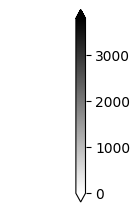

In [103]:
fig, ax = plt.subplots(1, 1, figsize = (1,2.5))
fraction = 1  # .05

norm = mpl.colors.Normalize(vmin = 0, vmax = max_transition_value+1)
cbar = ax.figure.colorbar(
    mpl.cm.ScalarMappable(norm = norm, cmap = 'binary'),
    ax = ax, 
    extend = 'both',
)

#cbar.ax.tick_params(labelsize=16)

ax.axis('off')
plt.savefig(f'{figures_dir}state_transitions_scalebar.svg', format='svg')
plt.show()

## 9-14

In [104]:
# get the entry probabilities
entry_pos = []
_n = 9
for stim_id in stim_ids:
    for stim_ind in spike_determinisms[int(stim_id)]:
        entry_pos.append(spike_determinisms[int(stim_id)][stim_ind][_n - 3])
Counter(entry_pos)

# get the transition probabilities
_slice = flips[(flips['n'] >= 9) & (flips['n'] <=14)]

# nondet2nondetspike (AB)
AB = _slice[(_slice['pre_determinism'] == 0.0) & (_slice['post_determinism'] == 0.5)].shape[0]
# nondetspike2nondet (BA)
BA = _slice[(_slice['pre_determinism'] == 0.5) & (_slice['post_determinism'] == 0.0)].shape[0]
# nondetspike2detspike (BC)
BC = _slice[(_slice['pre_determinism'] == 0.5) & (_slice['post_determinism'] == 1.0)].shape[0]
# detspike2nondetspike (CB)
CB = _slice[(_slice['pre_determinism'] == 1.0) & (_slice['post_determinism'] == 0.5)].shape[0]
# detspike2detnonspike (CD)
CD = _slice[(_slice['pre_determinism'] == 1.0) & (_slice['post_determinism'] == -1.0)].shape[0]
# detnonspike2detspike (DC)
DC = _slice[(_slice['pre_determinism'] == -1.0) & (_slice['post_determinism'] == 1.0)].shape[0]
# detnonspike2nondet (DA)
DA = _slice[(_slice['pre_determinism'] == -1.0) & (_slice['post_determinism'] == 0.0)].shape[0]
# nondet2detnonspike (AD)
AD = _slice[(_slice['pre_determinism'] == 0.0) & (_slice['post_determinism'] == -1.0)].shape[0]
# nondet2detspike (AC)
AC = _slice[(_slice['pre_determinism'] == 0.0) & (_slice['post_determinism'] == 1.0)].shape[0]
# detspike2nondet (CA)
CA = _slice[(_slice['pre_determinism'] == 1.0) & (_slice['post_determinism'] == 0.0)].shape[0]
# nondetspike2detnonspike (BD)
BD = _slice[(_slice['pre_determinism'] == 0.5) & (_slice['post_determinism'] == -1.0)].shape[0]
# detnonspike2nondetspike (DB)
DB = _slice[(_slice['pre_determinism'] == -1.0) & (_slice['post_determinism'] == 0.5)].shape[0]

total = AB+BA+BC+CB+CD+DC+DA+AD+AC+CA+BD+DB

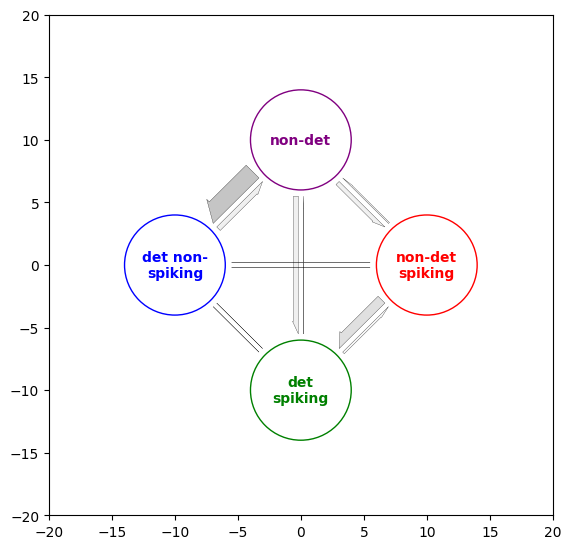

In [106]:
transitions = [
    ('A', 'B', 
     (node_pos['A'][0]-diag_offset+diag_radius_offset, node_pos['A'][1]-diag_offset-diag_radius_offset), 
     (node_pos['B'][0]-diag_offset-diag_radius_offset, node_pos['B'][1]-diag_offset+diag_radius_offset),
     AB
    ),
    ('A', 'C', 
     (node_pos['A'][0]-bidir_offset, node_pos['A'][1]-radius_offset), 
     (node_pos['C'][0]-bidir_offset, node_pos['C'][1]+radius_offset),
     AC
    ),
    ('A', 'D', 
     (node_pos['A'][0]-diag_offset-diag_radius_offset, node_pos['A'][1]+diag_offset-diag_radius_offset), 
     (node_pos['D'][0]-diag_offset+diag_radius_offset, node_pos['D'][1]+diag_offset+diag_radius_offset),
     AD
    ),
    ('B', 'A', 
     (node_pos['B'][0]+diag_offset-diag_radius_offset, node_pos['B'][1]+diag_offset+diag_radius_offset), 
     (node_pos['A'][0]+diag_offset+diag_radius_offset, node_pos['A'][1]+diag_offset-diag_radius_offset),
     BA
    ), 
    ('B', 'C', 
     (node_pos['B'][0]-diag_offset-diag_radius_offset, node_pos['B'][1]+diag_offset-diag_radius_offset),
     (node_pos['C'][0]-diag_offset+diag_radius_offset, node_pos['C'][1]+diag_offset+diag_radius_offset), 
     BC
    ),
    ('B', 'D', 
     (node_pos['B'][0]-radius_offset, node_pos['B'][1]+bidir_offset), 
     (node_pos['D'][0]+radius_offset, node_pos['D'][1]+bidir_offset),
     BD
    ), 
    ('C', 'A', 
     (node_pos['C'][0]+bidir_offset, node_pos['C'][1]+radius_offset), 
     (node_pos['A'][0]+bidir_offset, node_pos['A'][1]-radius_offset),
     CA
    ),
    ('C', 'B', 
     (node_pos['C'][0]+diag_offset+diag_radius_offset, node_pos['C'][1]-diag_offset+diag_radius_offset),
     (node_pos['B'][0]+diag_offset-diag_radius_offset, node_pos['B'][1]-diag_offset-diag_radius_offset), 
     CB
    ),
    ('C', 'D', 
     (node_pos['C'][0]+diag_offset-diag_radius_offset, node_pos['C'][1]+diag_offset+diag_radius_offset), 
     (node_pos['D'][0]+diag_offset+diag_radius_offset, node_pos['D'][1]+diag_offset-diag_radius_offset),
     CD
    ),
    ('D', 'A', 
     (node_pos['D'][0]+diag_offset+diag_radius_offset, node_pos['D'][1]-diag_offset+diag_radius_offset), 
     (node_pos['A'][0]+diag_offset-diag_radius_offset, node_pos['A'][1]-diag_offset-diag_radius_offset),
     DA
    ),
    ('D', 'B', 
     (node_pos['D'][0]+radius_offset, node_pos['D'][1]-bidir_offset), 
     (node_pos['B'][0]-radius_offset, node_pos['B'][1]-bidir_offset),
     DB
    ), 
    ('D', 'C', 
     (node_pos['D'][0]-diag_offset+diag_radius_offset, node_pos['D'][1]-diag_offset-diag_radius_offset), 
     (node_pos['C'][0]-diag_offset-diag_radius_offset, node_pos['C'][1]-diag_offset+diag_radius_offset),
     DC
    ),
]

# Create the figure and axis
fig, ax = plt.subplots(figsize = (6.5,6.5))

# Set the axis limits
ax.set_xlim([-20, 20])
ax.set_ylim([-20, 20])


# Add the states
for i, state in enumerate(states):
    x = node_pos[state][0]
    y = node_pos[state][1]
    ax.text(x, y, state_names[state], ha='center', va='center', fontsize=10, 
            fontweight='bold', color=state_colors[state])
    ax.add_patch(plt.Circle((x, y), 4, facecolor='white', edgecolor=state_colors[state]))

# Add the transitions
for transition in transitions:
    x1, y1 = transition[2]
    x2, y2 = transition[3]
    dx, dy = x2 - x1, y2 - y1
    ax.arrow(
        x1, y1, dx, dy, 
        head_width=head_width*(transition[4]/divisor), head_length=arrow_l, 
        width=10*(transition[4]/divisor),
        fc=[
            np.interp(
                transition[4], 
                np.linspace(0, max_transition_value+1, max_transition_value+1), 
                colors[:,i]) for i in range(3)
        ],
        ec='k', lw=.2,
        shape='left', length_includes_head=True)

# Show the plot
plt.savefig(f'{figures_dir}state_transitions_9-14.svg', format='svg')
plt.show()

## 15-20

In [108]:
# get the entry probabilities
entry_pos = []
_n = 15
for stim_id in stim_ids:
    for stim_ind in spike_determinisms[int(stim_id)]:
        entry_pos.append(spike_determinisms[int(stim_id)][stim_ind][_n - 3])
Counter(entry_pos)

# get the transition probabilities
_slice = flips[(flips['n'] >= 15) & (flips['n'] <=20)]

# nondet2nondetspike (AB)
AB = _slice[(_slice['pre_determinism'] == 0.0) & (_slice['post_determinism'] == 0.5)].shape[0]
# nondetspike2nondet (BA)
BA = _slice[(_slice['pre_determinism'] == 0.5) & (_slice['post_determinism'] == 0.0)].shape[0]
# nondetspike2detspike (BC)
BC = _slice[(_slice['pre_determinism'] == 0.5) & (_slice['post_determinism'] == 1.0)].shape[0]
# detspike2nondetspike (CB)
CB = _slice[(_slice['pre_determinism'] == 1.0) & (_slice['post_determinism'] == 0.5)].shape[0]
# detspike2detnonspike (CD)
CD = _slice[(_slice['pre_determinism'] == 1.0) & (_slice['post_determinism'] == -1.0)].shape[0]
# detnonspike2detspike (DC)
DC = _slice[(_slice['pre_determinism'] == -1.0) & (_slice['post_determinism'] == 1.0)].shape[0]
# detnonspike2nondet (DA)
DA = _slice[(_slice['pre_determinism'] == -1.0) & (_slice['post_determinism'] == 0.0)].shape[0]
# nondet2detnonspike (AD)
AD = _slice[(_slice['pre_determinism'] == 0.0) & (_slice['post_determinism'] == -1.0)].shape[0]
# nondet2detspike (AC)
AC = _slice[(_slice['pre_determinism'] == 0.0) & (_slice['post_determinism'] == 1.0)].shape[0]
# detspike2nondet (CA)
CA = _slice[(_slice['pre_determinism'] == 1.0) & (_slice['post_determinism'] == 0.0)].shape[0]
# nondetspike2detnonspike (BD)
BD = _slice[(_slice['pre_determinism'] == 0.5) & (_slice['post_determinism'] == -1.0)].shape[0]
# detnonspike2nondetspike (DB)
DB = _slice[(_slice['pre_determinism'] == -1.0) & (_slice['post_determinism'] == 0.5)].shape[0]

total = AB+BA+BC+CB+CD+DC+DA+AD+AC+CA+BD+DB

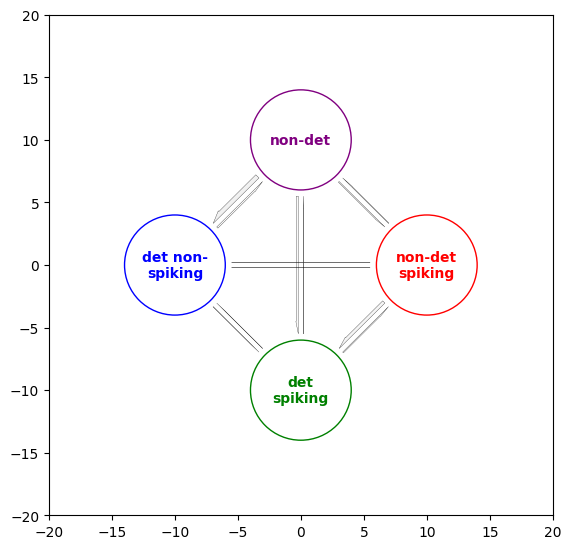

In [110]:
transitions = [
    ('A', 'B', 
     (node_pos['A'][0]-diag_offset+diag_radius_offset, node_pos['A'][1]-diag_offset-diag_radius_offset), 
     (node_pos['B'][0]-diag_offset-diag_radius_offset, node_pos['B'][1]-diag_offset+diag_radius_offset),
     AB
    ),
    ('A', 'C', 
     (node_pos['A'][0]-bidir_offset, node_pos['A'][1]-radius_offset), 
     (node_pos['C'][0]-bidir_offset, node_pos['C'][1]+radius_offset),
     AC
    ),
    ('A', 'D', 
     (node_pos['A'][0]-diag_offset-diag_radius_offset, node_pos['A'][1]+diag_offset-diag_radius_offset), 
     (node_pos['D'][0]-diag_offset+diag_radius_offset, node_pos['D'][1]+diag_offset+diag_radius_offset),
     AD
    ),
    ('B', 'A', 
     (node_pos['B'][0]+diag_offset-diag_radius_offset, node_pos['B'][1]+diag_offset+diag_radius_offset), 
     (node_pos['A'][0]+diag_offset+diag_radius_offset, node_pos['A'][1]+diag_offset-diag_radius_offset),
     BA
    ), 
    ('B', 'C', 
     (node_pos['B'][0]-diag_offset-diag_radius_offset, node_pos['B'][1]+diag_offset-diag_radius_offset),
     (node_pos['C'][0]-diag_offset+diag_radius_offset, node_pos['C'][1]+diag_offset+diag_radius_offset), 
     BC
    ),
    ('B', 'D', 
     (node_pos['B'][0]-radius_offset, node_pos['B'][1]+bidir_offset), 
     (node_pos['D'][0]+radius_offset, node_pos['D'][1]+bidir_offset),
     BD
    ), 
    ('C', 'A', 
     (node_pos['C'][0]+bidir_offset, node_pos['C'][1]+radius_offset), 
     (node_pos['A'][0]+bidir_offset, node_pos['A'][1]-radius_offset),
     CA
    ),
    ('C', 'B', 
     (node_pos['C'][0]+diag_offset+diag_radius_offset, node_pos['C'][1]-diag_offset+diag_radius_offset),
     (node_pos['B'][0]+diag_offset-diag_radius_offset, node_pos['B'][1]-diag_offset-diag_radius_offset), 
     CB
    ),
    ('C', 'D', 
     (node_pos['C'][0]+diag_offset-diag_radius_offset, node_pos['C'][1]+diag_offset+diag_radius_offset), 
     (node_pos['D'][0]+diag_offset+diag_radius_offset, node_pos['D'][1]+diag_offset-diag_radius_offset),
     CD
    ),
    ('D', 'A', 
     (node_pos['D'][0]+diag_offset+diag_radius_offset, node_pos['D'][1]-diag_offset+diag_radius_offset), 
     (node_pos['A'][0]+diag_offset-diag_radius_offset, node_pos['A'][1]-diag_offset-diag_radius_offset),
     DA
    ),
    ('D', 'B', 
     (node_pos['D'][0]+radius_offset, node_pos['D'][1]-bidir_offset), 
     (node_pos['B'][0]-radius_offset, node_pos['B'][1]-bidir_offset),
     DB
    ), 
    ('D', 'C', 
     (node_pos['D'][0]-diag_offset+diag_radius_offset, node_pos['D'][1]-diag_offset-diag_radius_offset), 
     (node_pos['C'][0]-diag_offset-diag_radius_offset, node_pos['C'][1]-diag_offset+diag_radius_offset),
     DC
    ),
]

# Create the figure and axis
fig, ax = plt.subplots(figsize = (6.5,6.5))

# Set the axis limits
ax.set_xlim([-20, 20])
ax.set_ylim([-20, 20])


# Add the states
for i, state in enumerate(states):
    x = node_pos[state][0]
    y = node_pos[state][1]
    ax.text(x, y, state_names[state], ha='center', va='center', fontsize=10, 
            fontweight='bold', color=state_colors[state])
    ax.add_patch(plt.Circle((x, y), 4, facecolor='white', edgecolor=state_colors[state]))

# Add the transitions
for transition in transitions:
    x1, y1 = transition[2]
    x2, y2 = transition[3]
    dx, dy = x2 - x1, y2 - y1
    ax.arrow(
        x1, y1, dx, dy, 
        head_width=head_width*(transition[4]/divisor), head_length=arrow_l, 
        width=10*(transition[4]/divisor),
        fc=[
            np.interp(
                transition[4], 
                np.linspace(0, max_transition_value+1, max_transition_value+1), 
                colors[:,i]) for i in range(3)
        ],
        ec='k', lw=.2,
        shape='left', length_includes_head=True)

# Show the plot
plt.savefig(f'{figures_dir}state_transitions_15-20.svg', format='svg')
plt.show()

## Graphviz

In [33]:
# Import necessary libraries
from graphviz import Digraph

# Define the states and transitions
states = ['State 1', 'State 2', 'State 3', 'State 4']
transitions = [
    ('State 1', 'State 2', 'Transition 1'),
    ('State 2', 'State 3', 'Transition 2'),
    ('State 3', 'State 4', 'Transition 3'),
    ('State 4', 'State 1', 'Transition 4'),
]

# Create a new Digraph object
dot = Digraph()

# Add the states and transitions to the graph
for state in states:
    dot.node(state)

for start, end, label in transitions:
    dot.edge(start, end, label)

# Set the layout engine and render the graph
dot.engine = 'dot'
dot.render('state_diagram', format='png')

'state_diagram.png'

In [34]:
# Import necessary libraries
from graphviz import Digraph

# Define the states and transitions
states = ['State 1', 'State 2', 'State 3', 'State 4']
state_positions = [(0,0)]
transitions = [
    ('State 1', 'State 2', 0.5),
    ('State 1', 'State 3', 0.3),
    ('State 1', 'State 4', 0.2),
    ('State 2', 'State 3', 0.7),
    ('State 2', 'State 4', 0.3),
    ('State 3', 'State 1', 0.4),
    ('State 3', 'State 4', 0.6),
    ('State 4', 'State 1', 0.2),
    ('State 4', 'State 2', 0.4),
    ('State 4', 'State 3', 0.4)
]

# Create a new Digraph object
dot = Digraph()

# Add the states and transitions to the graph
for state in states:
    dot.node(state)

for start, end, prob in transitions:
    dot.edge(start, end, label=str(prob), penwidth = str(prob*10))

# Set the layout engine and render the graph
dot.engine = 'dot'
dot.render('state_diagram_prob', format='png')


'state_diagram_prob.png'

In [35]:
# Import necessary libraries
from graphviz import Digraph

# Define the states and transitions
states = ['State 1', 'State 2', 'State 3', 'State 4']
transitions = [
    ('State 1', 'State 2', 0.5),
    ('State 1', 'State 3', 0.3),
    ('State 1', 'State 4', 0.2),
    ('State 2', 'State 3', 0.7),
    ('State 2', 'State 4', 0.3),
    ('State 3', 'State 1', 0.4),
    ('State 3', 'State 4', 0.6),
    ('State 4', 'State 1', 0.2),
    ('State 4', 'State 2', 0.4),
    ('State 4', 'State 3', 0.4)
]

# Define the positions of the nodes
pos = {
    'State 1': '0,0!',
    'State 2': '1,1!',
    'State 3': '0,2!',
    'State 4': '-1,1!'
}

# Create a new Digraph object
dot = Digraph()

# Add the states and transitions to the graph
for state in states:
    dot.node(state, pos=pos[state])

for start, end, prob in transitions:
    dot.edge(start, end, label=str(prob), penwidth=str(prob*5))

# Set the layout engine and render the graph
dot.engine = 'neato'
dot.render('state_diagram_prob_thickness_diamond', format='png')


'state_diagram_prob_thickness_diamond.png'

In [36]:
 

# Create a new Digraph object
dot = Digraph()

# Add the four states to the diagram
node_labels = ['A','B','C','D']
node_pos = {
    'A':(0,10),
    'B':(10,0),
    'C':(0,-10),
    'D':(-10,0)
}

dot.node('A', 'State A')
dot.node('B', 'State B')
dot.node('C', 'State C')
dot.node('D', 'State D')

# Add the state transitions to the diagram
for node_label0 in node_labels:
    for node_label1 in node_labels:
        if node_label0 != node_label1:
            dot.edge(node_label0, node_label1, label=node_label0 + node_label1)


# Set some layout options to make the diagram look pretty
dot.attr(rankdir='LR')
dot.attr(fontsize='10')
dot.attr(fontname='Helvetica')
dot.attr('node', shape='square')

# Render the diagram
dot.render('state_transition_diagram', format='png', view=True)

'state_transition_diagram.png'